<a href="https://colab.research.google.com/github/HazemAbdo/FloodSense/blob/classification%2Fdeep_learning/SI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python-headless

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Helpers

In [3]:
def show_img(img,title=""):
      plt.imshow(img)
      plt.title(title)
      plt.show()

# Images reading 

In [4]:
import zipfile

# specify the path to your zip file
zip_path = "drive/MyDrive/Copy of dataset.zip"

# create a ZipFile object
with zipfile.ZipFile(zip_path, 'r') as zip_ref:

    # extract all contents to a specified directory
    zip_ref.extractall("/content")

In [5]:
import os
import cv2
import numpy as np

# specify the paths to the "flooded" and "non-flooded" folders
flooded_path = "dataset/flooded"
non_flooded_path = "dataset/non-flooded"

# create empty numpy arrays to store the images
# flooded = np.empty((0, 224, 224))
# non_flooded = np.empty((0, 224, 224))

# # loop through the images in the "flooded" folder
# for filename in os.listdir(flooded_path):
#     img = cv2.imread(os.path.join(flooded_path, filename), cv2.IMREAD_GRAYSCALE)
#     img = cv2.resize(img, (224, 224)) # resize the image to (224, 224)
#     img = img.astype('float32') / 255.0  # normalize pixel values to the range of [0, 1]
#     img = np.expand_dims(img, axis=0) # add an extra dimension for concatenation
#     flooded = np.concatenate((flooded, img), axis=0)

# # loop through the images in the "non-flooded" folder
# for filename in os.listdir(non_flooded_path):
#     img = cv2.imread(os.path.join(non_flooded_path, filename), cv2.IMREAD_GRAYSCALE)
#     img = cv2.resize(img, (224, 224)) # resize the image to (224, 224)
#     img = img.astype('float32') / 255.0  # normalize pixel values to the range of [0, 1]
#     img = np.expand_dims(img, axis=0) # add an extra dimension for concatenation
#     non_flooded = np.concatenate((non_flooded, img), axis=0)

flooded = np.empty((0, 224, 224, 3))
non_flooded = np.empty((0, 224, 224, 3))
# loop through the images in the "flooded" folder
for filename in os.listdir(flooded_path):
    img = cv2.imread(os.path.join(flooded_path, filename), cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224, 224)) # resize the image to (224, 224)
    img = img.astype('float32') / 255.0  # normalize pixel values to the range of [0, 1]
    img = np.expand_dims(img, axis=0) # add an extra dimension for concatenation
    flooded = np.concatenate((flooded, img), axis=0)

# loop through the images in the "non-flooded" folder
for filename in os.listdir(non_flooded_path):
    img = cv2.imread(os.path.join(non_flooded_path, filename), cv2.IMREAD_COLOR)
    img = cv2.resize(img, (224, 224)) # resize the image to (224, 224)
    img = img.astype('float32') / 255.0  # normalize pixel values to the range of [0, 1]
    img = np.expand_dims(img, axis=0) # add an extra dimension for concatenation
    non_flooded = np.concatenate((non_flooded, img), axis=0)
  
print(flooded.shape)
print(non_flooded.shape)

(461, 224, 224, 3)
(461, 224, 224, 3)


In [6]:
flooded[0].shape

(224, 224, 3)

In [7]:
from sklearn.model_selection import train_test_split

# concatenate the flooded and non-flooded images into a single numpy array
X = np.concatenate((flooded, non_flooded), axis=0)

# create the corresponding labels
y = np.concatenate((np.ones(flooded.shape[0]), np.zeros(non_flooded.shape[0])), axis=0)

# 80% training, 10% validation, 10% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)

print(X_train.shape, y_train.shape)  # should output the shapes of the training data
print(X_test.shape, y_test.shape)  # should output the shapes of the training data
print(X_val.shape, y_val.shape)  # should output the shapes of the validation data

(737, 224, 224, 3) (737,)
(93, 224, 224, 3) (93,)
(92, 224, 224, 3) (92,)


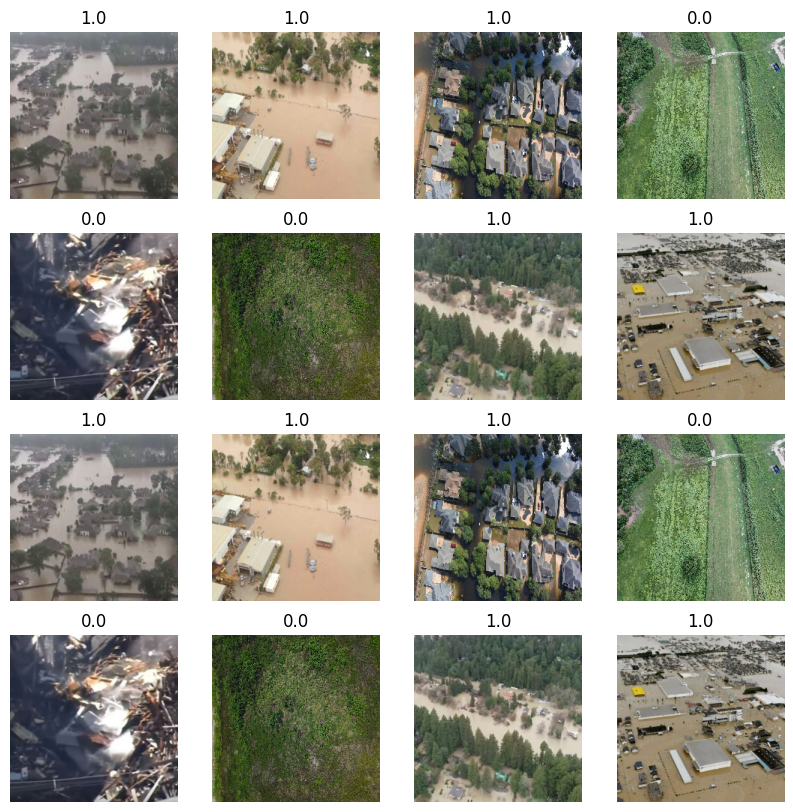

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

from IPython.core.pylabtools import figsize



nrows = 4
ncols = 4

fig, ax = plt.subplots(nrows,ncols,figsize = (10,10))
ax = ax.flatten()

for i in range(nrows*ncols):
    pic = X_train[i%8]
    ax[i].imshow(pic)
    ax[i].set_title(y_train[i%8])
    ax[i].set_axis_off()
plt.show()

### Deep-learning approach

1. Let’s preprocess our data using the compose method, which is a simple method to apply multiple preprocessing functions like normalization and data augmentation to our dataset.
2. Let’s use ImageFolder to create a pytorch dataset. PyTorch infers the class automatically if the subdirectories structure is well defined (as in our case).
3. Use the DataLoader to slice our data in batches.

In [27]:
# import torch
# from torch.utils.data import Dataset, TensorDataset
# class CustomTensorDataset(Dataset):
#     """TensorDataset with support of transforms.
#     """
#     def __init__(self, tensors, transform=None):
#         assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
#         self.tensors = tensors
#         self.transform = transform

#     def __getitem__(self, index):
#         x = self.tensors[0][index]

#         if self.transform:
#             x = self.transform(x)

#         y = self.tensors[1][index]

#         return x, y

#     def __len__(self):
#         return self.tensors[0].size(0)


# # Dataset with flipping tranformations

# def vflip(tensor):
#     """Flips tensor vertically.
#     """
#     tensor = tensor.flip(1)
#     return tensor


# def hflip(tensor):
#     """Flips tensor horizontally.
#     """
#     tensor = tensor.flip(2)
#     return tensor

# def normalize(tensor):
#     mean=[0.485, 0.456, 0.406]
#     std=[0.229, 0.224, 0.225]
#     tensor = tensor.permute(1, 2, 0)
#     tensor = (tensor - mean) / std
#     tensor = tensor.permute(2, 0, 1)
#     return tensor

# def transform_func(tensor):
#     tensor=normalize(tensor)
#     tensor = vflip(tensor)
#     tensor = hflip(tensor)
#     return tensor
    

In [32]:
import torch
import torchvision
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms



#transformations
# train_transforms = transforms.Compose([transforms.Resize((224,224)),
#                                        transforms.ToTensor(),                                
#                                        torchvision.transforms.Normalize(
#                                            mean=[0.485, 0.456, 0.406],
#                                            std=[0.229, 0.224, 0.225],
#     ),
#                                        ])
# test_transforms = transforms.Compose([transforms.Resize((224,224)),
#                                       transforms.ToTensor(),
#                                       torchvision.transforms.Normalize(
#                                           mean=[0.485, 0.456, 0.406],
#                                           std=[0.229, 0.224, 0.225],
#     ),
#                                       ])

# convert the numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

# create a PyTorch dataset from the tensors
train_dataset = CustomTensorDataset(tensors=(X_train_tensor, y_train_tensor))
val_dataset = CustomTensorDataset(tensors=(X_val_tensor, y_val_tensor))
test_dataset = CustomTensorDataset(tensors=(X_test_tensor, y_test_tensor))

# create a PyTorch DataLoader for the training set
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# create a PyTorch DataLoader for the validation set
validationloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# create a PyTorch DataLoader for the test set
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [33]:
# get the shape of the input data
input_shape = val_dataset[0][0].size()
print('Input shape:', input_shape)

# get the shape of the target data
target_shape = val_dataset[0][1]
print('Target shape:', target_shape)

Input shape: torch.Size([224, 224, 3])
Target shape: tensor(0.)


In [16]:
def make_train_step(model, optimizer, loss_fn):
  def train_step(x,y):
    #make prediction
    yhat = model(x)
    #enter train mode
    model.train()
    #compute loss
    loss = loss_fn(yhat,y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    #optimizer.cleargrads()

    return loss
  return train_step

In [17]:
from torchvision import datasets, models, transforms
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
model = models.resnet18(pretrained=True)

#freeze all params
for params in model.parameters():
  params.requires_grad_ = False

#add a new final layer
nr_filters = model.fc.in_features  #number of input features of last layer
model.fc = nn.Linear(nr_filters, 1)

model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 165MB/s]


In [18]:
# import torch
# import torch.nn as nn

# class RegularizedBCELoss(nn.Module):
#     def __init__(self, alpha):
#         super().__init__()
#         self.alpha = alpha
#         self.bce_loss = nn.BCEWithLogitsLoss()

#     def forward(self, output, labels, epoch_output, prev_epoch_output):
#         bce_loss = self.bce_loss(output, labels)
#         reg_loss = self.bce_loss(epoch_output, prev_epoch_output)
#         loss = bce_loss + self.alpha * reg_loss
#         return loss

In [30]:
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler

#loss
loss_fn = BCEWithLogitsLoss() #binary cross entropy with sigmoid, so no need to use sigmoid in the model

#optimizer
optimizer = torch.optim.Adam(model.fc.parameters()) 

#train step
train_step = make_train_step(model, optimizer, loss_fn)

In [21]:
!pip install tqdm
from tqdm import tqdm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
losses = []
val_losses = []

epoch_train_losses = []
epoch_val_losses = []

n_epochs = 10
early_stopping_tolerance = 3
early_stopping_threshold = 0.03

for epoch in range(n_epochs):
  epoch_loss = 0
  for i ,data in tqdm(enumerate(trainloader), total = len(trainloader)): #iterate ove batches
    x_batch , y_batch = data
    x_batch = x_batch.permute(0, 3, 1, 2)
    x_batch = x_batch.to(device) #move to gpu
    y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
    y_batch = y_batch.to(device) #move to gpu


    loss = train_step(x_batch, y_batch)
    epoch_loss += loss/len(trainloader)
    losses.append(loss)
    
  epoch_train_losses.append(epoch_loss)
  print('\nEpoch : {}, train loss : {}'.format(epoch+1,epoch_loss))

  #validation doesnt requires gradient
  with torch.no_grad():
    cum_loss = 0
    for x_batch, y_batch in validationloader:
      x_batch = x_batch.permute(0, 3, 1, 2)
      x_batch = x_batch.to(device)
      y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
      y_batch = y_batch.to(device)

      #model to eval mode
      model.eval()

      yhat = model(x_batch)
      val_loss = loss_fn(yhat,y_batch)
      cum_loss += loss/len(validationloader)
      val_losses.append(val_loss.item())


    epoch_val_losses.append(cum_loss)
    print('Epoch : {}, val loss : {}'.format(epoch+1,cum_loss))  
    
    best_loss = min(epoch_val_losses)
    
    #save best model
    if cum_loss <= best_loss:
      best_model_wts = model.state_dict()
    
    #early stopping
    early_stopping_counter = 0
    if cum_loss > best_loss:
      early_stopping_counter +=1

    if (early_stopping_counter == early_stopping_tolerance) or (best_loss <= early_stopping_threshold):
      print("/nTerminating: early stopping")
      break #terminate training
    
#load best model
model.load_state_dict(best_model_wts)

100%|██████████| 12/12 [00:02<00:00,  4.97it/s]



Epoch : 1, train loss : 0.2190018892288208
Epoch : 1, val loss : 0.22194305062294006


100%|██████████| 12/12 [00:02<00:00,  5.08it/s]



Epoch : 2, train loss : 0.20372024178504944
Epoch : 2, val loss : 0.21328967809677124


100%|██████████| 12/12 [00:02<00:00,  5.08it/s]



Epoch : 3, train loss : 0.19922994077205658
Epoch : 3, val loss : 0.24074599146842957


100%|██████████| 12/12 [00:02<00:00,  5.05it/s]



Epoch : 4, train loss : 0.17637795209884644
Epoch : 4, val loss : 0.16659140586853027


100%|██████████| 12/12 [00:02<00:00,  5.02it/s]



Epoch : 5, train loss : 0.17605993151664734
Epoch : 5, val loss : 0.12766994535923004


100%|██████████| 12/12 [00:02<00:00,  5.03it/s]



Epoch : 6, train loss : 0.170113205909729
Epoch : 6, val loss : 0.14151501655578613


100%|██████████| 12/12 [00:02<00:00,  5.05it/s]



Epoch : 7, train loss : 0.14958132803440094
Epoch : 7, val loss : 0.09094133228063583


100%|██████████| 12/12 [00:02<00:00,  5.03it/s]



Epoch : 8, train loss : 0.15898720920085907
Epoch : 8, val loss : 0.10758575052022934


100%|██████████| 12/12 [00:02<00:00,  4.99it/s]



Epoch : 9, train loss : 0.15332043170928955
Epoch : 9, val loss : 0.2942976951599121


100%|██████████| 12/12 [00:02<00:00,  4.97it/s]



Epoch : 10, train loss : 0.1423806995153427
Epoch : 10, val loss : 0.13127712905406952


<All keys matched successfully>

In [45]:
from sklearn.metrics import confusion_matrix, classification_report
estimated=[]
true=[]
for x_batch, y_batch in testloader:
  x_batch = x_batch.permute(0, 3, 1, 2)
  x_batch = x_batch.to(device)
  y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
  y_batch = y_batch.to(device)
  model.eval()
  yhat = model(x_batch)
  yhat = torch.sigmoid(yhat)
  yhat = torch.round(yhat)
  estimated.append(yhat)
  true.append(y_batch)
print(confusion_matrix(y_batch.cpu().detach().numpy(), yhat.cpu().detach().numpy()))
print(classification_report(y_batch.cpu().detach().numpy(), yhat.cpu().detach().numpy()))
    


[[15  1]
 [ 0 13]]
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97        16
         1.0       0.93      1.00      0.96        13

    accuracy                           0.97        29
   macro avg       0.96      0.97      0.97        29
weighted avg       0.97      0.97      0.97        29

